# <a id='toc1_'></a>[Summary](#toc0_)

**The goal of the analytical exercise in this notebook is to apply pre-trained NLTK sentiment analysis model to a subset of game reviews from Steam platform and compare the modelled results with the provided user recommendation**.

Following that, a drilldown across different dimensions is performed in search of likely 'culprit' group of records that may be particularly misleading for that model.

**Dataset source:** https://www.kaggle.com/datasets/luthfim/steam-reviews-dataset

**Table of contents**<a id='toc0_'></a>    
- [Summary](#toc1_)    
- [Imports & setup](#toc2_)    
- [Load, explore & clean data](#toc3_)    
- [Analysis](#toc4_)    
  - [Exploratory analysis](#toc4_1_)    
    - [What time period does this dataset cover ?](#toc4_1_1_)    
    - [Which games are reviewed ?](#toc4_1_2_)    
    - [How helpful in general are the reviews within the dataset, according to other Steam users ?](#toc4_1_3_)    
    - [How funny the comments are ?](#toc4_1_4_)    
  - [Sentiment analysis](#toc4_2_)    
    - [Evaluate with nltk model & compare against user recommendation](#toc4_2_1_)    
      - [Cross-sectional comparison across titles](#toc4_2_1_1_)    
    - [Evaluate accuracy of NLTK model](#toc4_2_2_)    
    - [Check accuracy for different groupings of comments](#toc4_2_3_)    
      - [Drilldown across game titles](#toc4_2_3_1_)    
      - [Take amount of reviews into account](#toc4_2_3_2_)    
      - [Only helpful reviews](#toc4_2_3_3_)    
      - [Excluding reviews deemed as funny](#toc4_2_3_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Imports & setup](#toc0_)


In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.sentiment import SentimentIntensityAnalyzer

# <a id='toc3_'></a>[Load, explore & clean data](#toc0_)

In [4]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
data_folder_path = os.path.join(parent_dir, 'Data') #data subfolder in local repo
csv_file_name = 'steam_reviews.csv'
csv_file_path = os.path.join(data_folder_path, csv_file_name)


In [5]:
steam_reviews = pd.read_csv(csv_file_path)
display(steam_reviews.head(5))
display(steam_reviews.shape)

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title
0,2019-02-10,2,4,578,False,Recommended,&gt Played as German Reich&gt Declare war on B...,Expansion - Hearts of Iron IV: Man the Guns
1,2019-02-10,0,0,184,False,Recommended,yes.,Expansion - Hearts of Iron IV: Man the Guns
2,2019-02-07,0,0,892,False,Recommended,Very good game although a bit overpriced in my...,Expansion - Hearts of Iron IV: Man the Guns
3,2018-06-14,126,1086,676,False,Recommended,Out of all the reviews I wrote This one is pro...,Dead by Daylight
4,2017-06-20,85,2139,612,False,Recommended,Disclaimer I survivor main. I play games for f...,Dead by Daylight


(434891, 8)

In [6]:
steam_reviews.dtypes

date_posted               object
funny                      int64
helpful                    int64
hour_played                int64
is_early_access_review      bool
recommendation            object
review                    object
title                     object
dtype: object

In [7]:
steam_reviews['date_posted'] = pd.to_datetime(steam_reviews['date_posted']) #convert to datetime for ease of linear plotting

In [8]:
steam_reviews.isna().sum()

date_posted                  0
funny                        0
helpful                      0
hour_played                  0
is_early_access_review       0
recommendation               0
review                    1516
title                        0
dtype: int64

We can keep the records without text body for the purpose of exploratory analysis, but they will need to be filtered out for sentiment analysis later

# <a id='toc4_'></a>[Analysis](#toc0_)

## <a id='toc4_1_'></a>[Exploratory analysis](#toc0_)

### <a id='toc4_1_1_'></a>[What time period does this dataset cover ?](#toc0_)

In [9]:
display(f"Earliest review posted at: {steam_reviews['date_posted'].min()}")
display(f"Latest review posted at: {steam_reviews['date_posted'].max()}")

'Earliest review posted at: 2010-12-20 00:00:00'

'Latest review posted at: 2019-02-16 00:00:00'

### <a id='toc4_1_2_'></a>[Which games are reviewed ?](#toc0_)

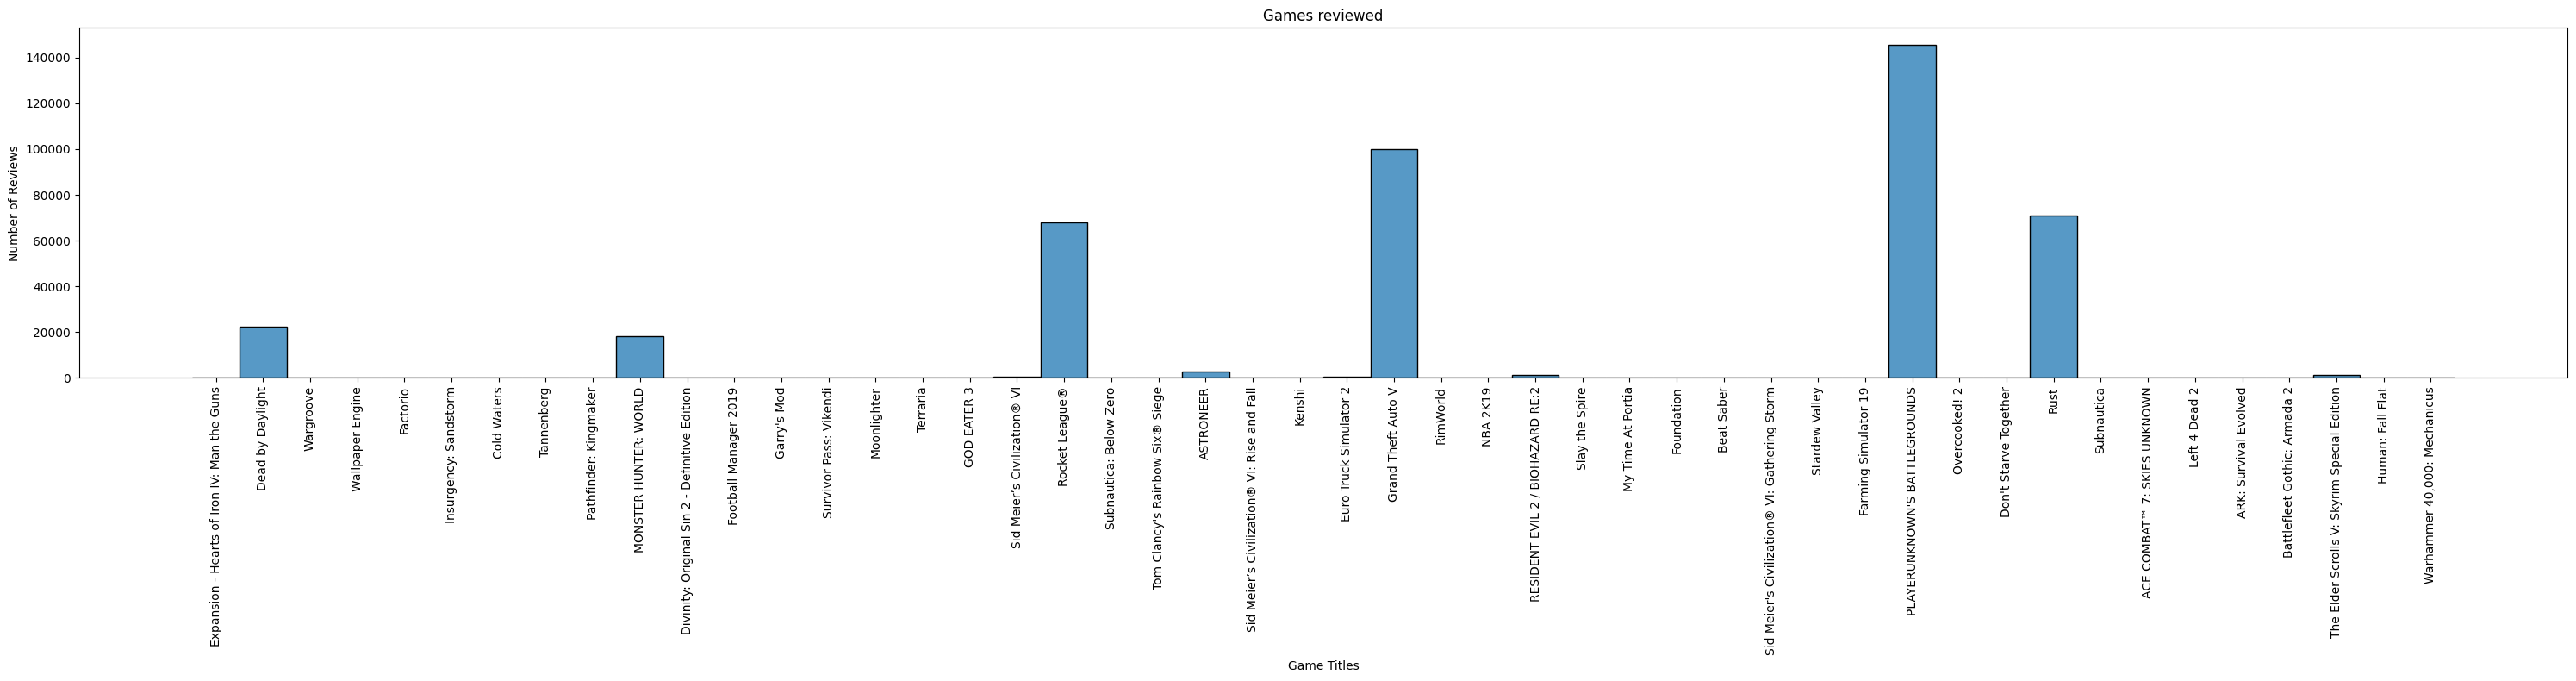

In [17]:
plt.figure(figsize=(30, 8))  # Adjust the figure size as needed
sns.histplot(data=steam_reviews, x='title', stat='count', kde=False)
plt.title('Games reviewed')
plt.xlabel('Game Titles')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

### <a id='toc4_1_3_'></a>[How helpful in general are the reviews within the dataset, according to other Steam users ?](#toc0_)

In [18]:
steam_reviews['helpful'] = pd.to_numeric(steam_reviews['helpful'], errors='coerce').astype(int)

In [19]:
print(f"Minimum: {int(steam_reviews['helpful'].min())}, Maximum: {int(steam_reviews['helpful'].max())}, Mean: {np.round(steam_reviews['helpful'].mean(),2)}, Median: {np.round(steam_reviews['helpful'].median(),2)}")

Minimum: 0, Maximum: 28171, Mean: 1.0, Median: 0.0


In [20]:
steam_reviews['helpful'].value_counts()

helpful
0      399656
1       18939
2        7251
3        3486
4        1440
        ...  
262         1
135         1
284         1
325         1
174         1
Name: count, Length: 447, dtype: int64

**People generally rarely bother to leave their feedback regarding the helpfulness of the review**

### <a id='toc4_1_4_'></a>[How funny the comments are ?](#toc0_)

In [21]:
steam_reviews['funny'] = pd.to_numeric(steam_reviews['funny'], errors='coerce').astype(int)

In [22]:
print(f"Minimum: {int(steam_reviews['funny'].min())}, Maximum: {int(steam_reviews['funny'].max())}, Mean: {np.round(steam_reviews['funny'].mean(),2)}, Median: {np.round(steam_reviews['funny'].median(),2)}")

Minimum: -8, Maximum: 7472, Mean: 0.37, Median: 0.0


In [23]:
steam_reviews['funny'].value_counts()

funny
0       399656
1        23352
2         6207
3         2345
4          962
         ...  
391          1
1064         1
5438         1
225          1
840          1
Name: count, Length: 246, dtype: int64

## <a id='toc4_2_'></a>[Sentiment analysis](#toc0_)

### <a id='toc4_2_1_'></a>[Evaluate with nltk model & compare against user recommendation](#toc0_)

In [24]:
steam_reviews = steam_reviews[~steam_reviews['review'].isna()].astype(str) #remove null values from 'review' column

In [25]:
sia = SentimentIntensityAnalyzer()

In [26]:
def analyze_sentiment(review):
    sentiment_score = sia.polarity_scores(review)['compound']
    if sentiment_score >= 0.1:
        return 'Positive'
    elif sentiment_score <= -0.1:
        return 'Negative'
    else:
        return 'Neutral'

In [27]:
steam_reviews['sentiment'] = steam_reviews['review'].apply(analyze_sentiment)
display(steam_reviews[['sentiment','review']].head(5))

,sentiment,review
0,Neutral,&gt Played as German Reich&gt Declare war on B...
1,Positive,yes.
2,Positive,Very good game although a bit overpriced in my...
3,Positive,Out of all the reviews I wrote This one is pro...
4,Negative,Disclaimer I survivor main. I play games for f...


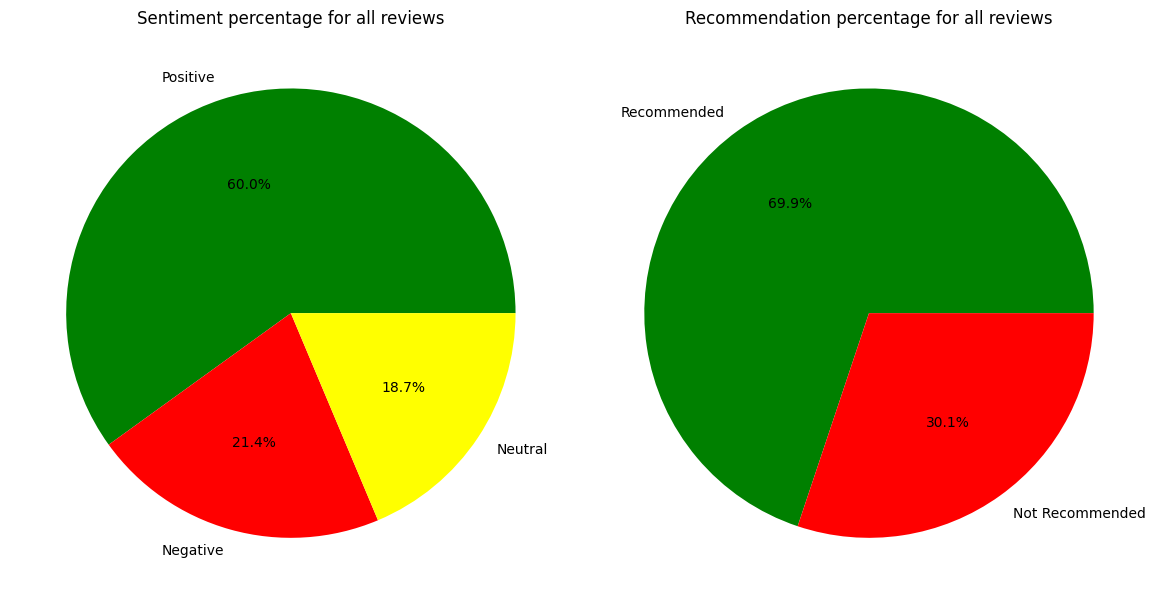

In [34]:
# Create subplots for two pie charts side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart for sentiment percentage
sentiment_counts = steam_reviews['sentiment'].value_counts()
axes[0].pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['green', 'red', 'yellow'])
axes[0].set_title('Sentiment percentage for all reviews')

# Pie chart for recommendation percentage
recommendation_counts = steam_reviews['recommendation'].value_counts()
axes[1].pie(recommendation_counts, labels=recommendation_counts.index, autopct='%1.1f%%', colors=['green','red'])
axes[1].set_title('Recommendation percentage for all reviews')

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

Sentiment analysis roughly matches the user recommendations. Comments with 'neutral' sentiment seem to split almost equally between the 'Recommended'/'Not recommended' reviews.

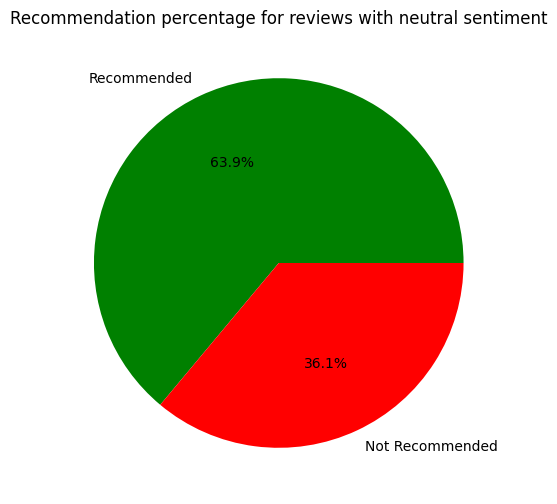

In [32]:
# Filter the DataFrame for reviews with neutral sentiment
neutral_reviews = steam_reviews[steam_reviews['sentiment'] == 'Neutral']

# Calculate recommendation counts for neutral sentiment reviews
recommendation_counts = neutral_reviews['recommendation'].value_counts()

# Create the pie chart
plt.figure(figsize=(8, 6))
plt.pie(recommendation_counts, labels=recommendation_counts.index, autopct='%1.1f%%', colors=['green','red'])
plt.title('Recommendation percentage for reviews with neutral sentiment')
plt.show()

We can check for mismatching sentiment/recommendation records

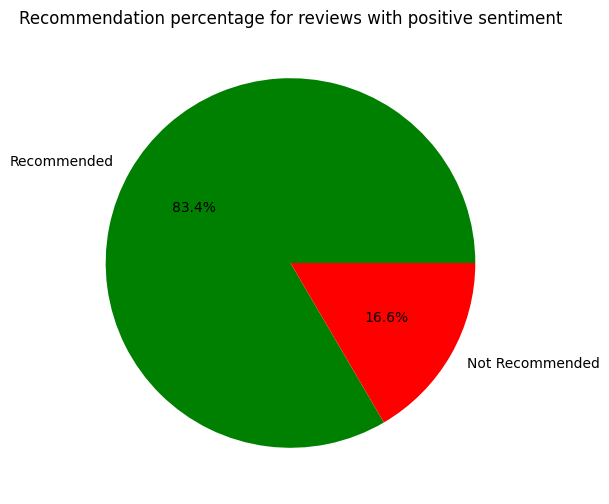

In [31]:
# Filter the DataFrame for reviews with positive sentiment
positive_reviews = steam_reviews[steam_reviews['sentiment'] == 'Positive']

# Calculate recommendation counts for positive sentiment reviews
recommendation_counts = positive_reviews['recommendation'].value_counts()

# Create the pie chart
plt.figure(figsize=(8, 6))
plt.pie(recommendation_counts, labels=recommendation_counts.index, autopct='%1.1f%%', colors=['green','red'])
plt.title('Recommendation percentage for reviews with positive sentiment')
plt.show()

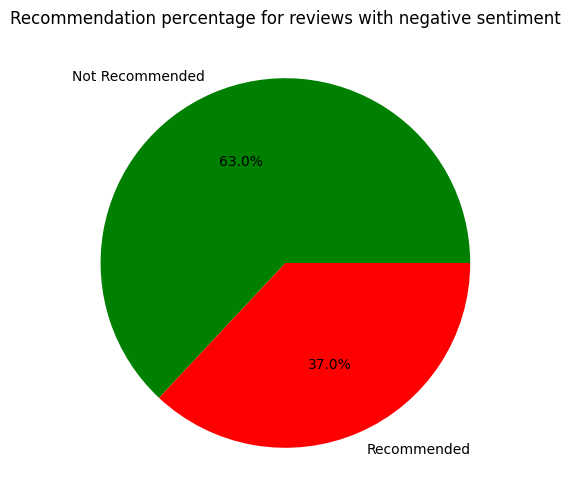

In [35]:
# Filter the DataFrame for reviews with negative sentiment
negative_reviews = steam_reviews[steam_reviews['sentiment'] == 'Negative']

# Calculate recommendation counts for negative sentiment reviews
recommendation_counts = negative_reviews['recommendation'].value_counts()

# Create the pie chart
plt.figure(figsize=(8, 6))
plt.pie(recommendation_counts, labels=recommendation_counts.index, autopct='%1.1f%%', colors=['green','red'])
plt.title('Recommendation percentage for reviews with negative sentiment')
plt.show()

The match between model predicted sentiment and user recommendation is imperfect, we can look more closely at some of the mismatching examples

In [38]:
steam_reviews[(steam_reviews['sentiment']=='Negative') & (steam_reviews['recommendation']=='Recommended')]['review'].sample(15).to_list()

['Land get loot get killed across the map REPEAT! (Amazing game love it!)',
 "Dead by Daylight is a refreshing game with cool ideas but the bugs are very annoying. the endless loading screen (no matter if I play as survivor killer or only trying to get in a lobby) not being able to see my character (in most cases I cannot even escape)I am really having a lot of fun this game is great and the bugs wouldn't be so bad but it happens so often. On bad days I restart the every three to four rounds which is sad. I also read that these bugs are very common and not since only a few weeks they do exist for a long amount of time now.Another point which I can't really understand are those many DLCs. Yea if I do not want them I do not have to purchase them but the game isn't even finished yet and still has so many issues. Why don't work on that first?Please fix your game devs this game makes so much fun and it would be a shame if I would stop playing it because of the issues.",
 'best running simul

In [39]:
steam_reviews[(steam_reviews['sentiment']=='Positive') & (steam_reviews['recommendation']=='Not Recommended')]['review'].sample(15).to_list()

['game made for filthy console casual peasants who dont use the master race keyboard',
 "The single player mode is fairly decent I expected somethiing better but it was fun nonetheless. On the other hand based on my short experience online the multiplayer sucks I got spawn killed every single time. If you are a Rockstar Games fan like myself buy this game on sale otherwise it's not worth it.",
 'Now lets be honest dead by daylight is a great game and there is no doubt about it but when it tries to compare to other hide and seek horror type games it doesnt even come close. It is a fun game but no where near the thrill and excitment that Friday the 13 has so in my opinion if your looking to get a game like this get friday the 13th its scarier way harder and overall more fun. this game is really fast paste and there is only one way to get out which makes it very repetitve while friday the 13th has mulitple diffrent senrious. That is just what I think.',
 "Avarage age of community is too l

**Amongst the False positive and False negative records, we can observe examples of sarcastic comments and also comments with more nuanced criticism which is the followed by users final recommendation or lack thereof.**

#### <a id='toc4_2_1_1_'></a>[Cross-sectional comparison across titles](#toc0_)

In [37]:
reviews_grouped_snt = steam_reviews[['title','sentiment','review']].groupby(['title','sentiment']).count().reset_index().rename(columns={'review':'reviews'}).sort_values('reviews',ascending=False) #group by sentiment

reviews_grouped_rcd = steam_reviews[['title','recommendation','review']].groupby(['title','recommendation']).count().reset_index().rename(columns={'review':'reviews'}).sort_values('reviews',ascending=False) #group by recommendation

display(reviews_grouped_snt, reviews_grouped_rcd)

,title,sentiment,reviews
75,PLAYERUNKNOWN'S BATTLEGROUNDS,Positive,78933
48,Grand Theft Auto V,Positive,54848
86,Rocket League®,Positive,49436
89,Rust,Positive,43062
73,PLAYERUNKNOWN'S BATTLEGROUNDS,Negative,37093
...,...,...,...
29,Expansion - Hearts of Iron IV: Man the Guns,Neutral,1
56,Kenshi,Neutral,1
41,GOD EATER 3,Negative,1
105,Subnautica: Below Zero,Neutral,1


,title,recommendation,reviews
44,PLAYERUNKNOWN'S BATTLEGROUNDS,Recommended,86726
51,Rocket League®,Recommended,61624
27,Grand Theft Auto V,Recommended,58814
43,PLAYERUNKNOWN'S BATTLEGROUNDS,Not Recommended,58120
53,Rust,Recommended,55649
...,...,...,...
58,Slay the Spire,Not Recommended,2
41,Overcooked! 2,Not Recommended,1
65,Terraria,Not Recommended,1
33,Left 4 Dead 2,Not Recommended,1


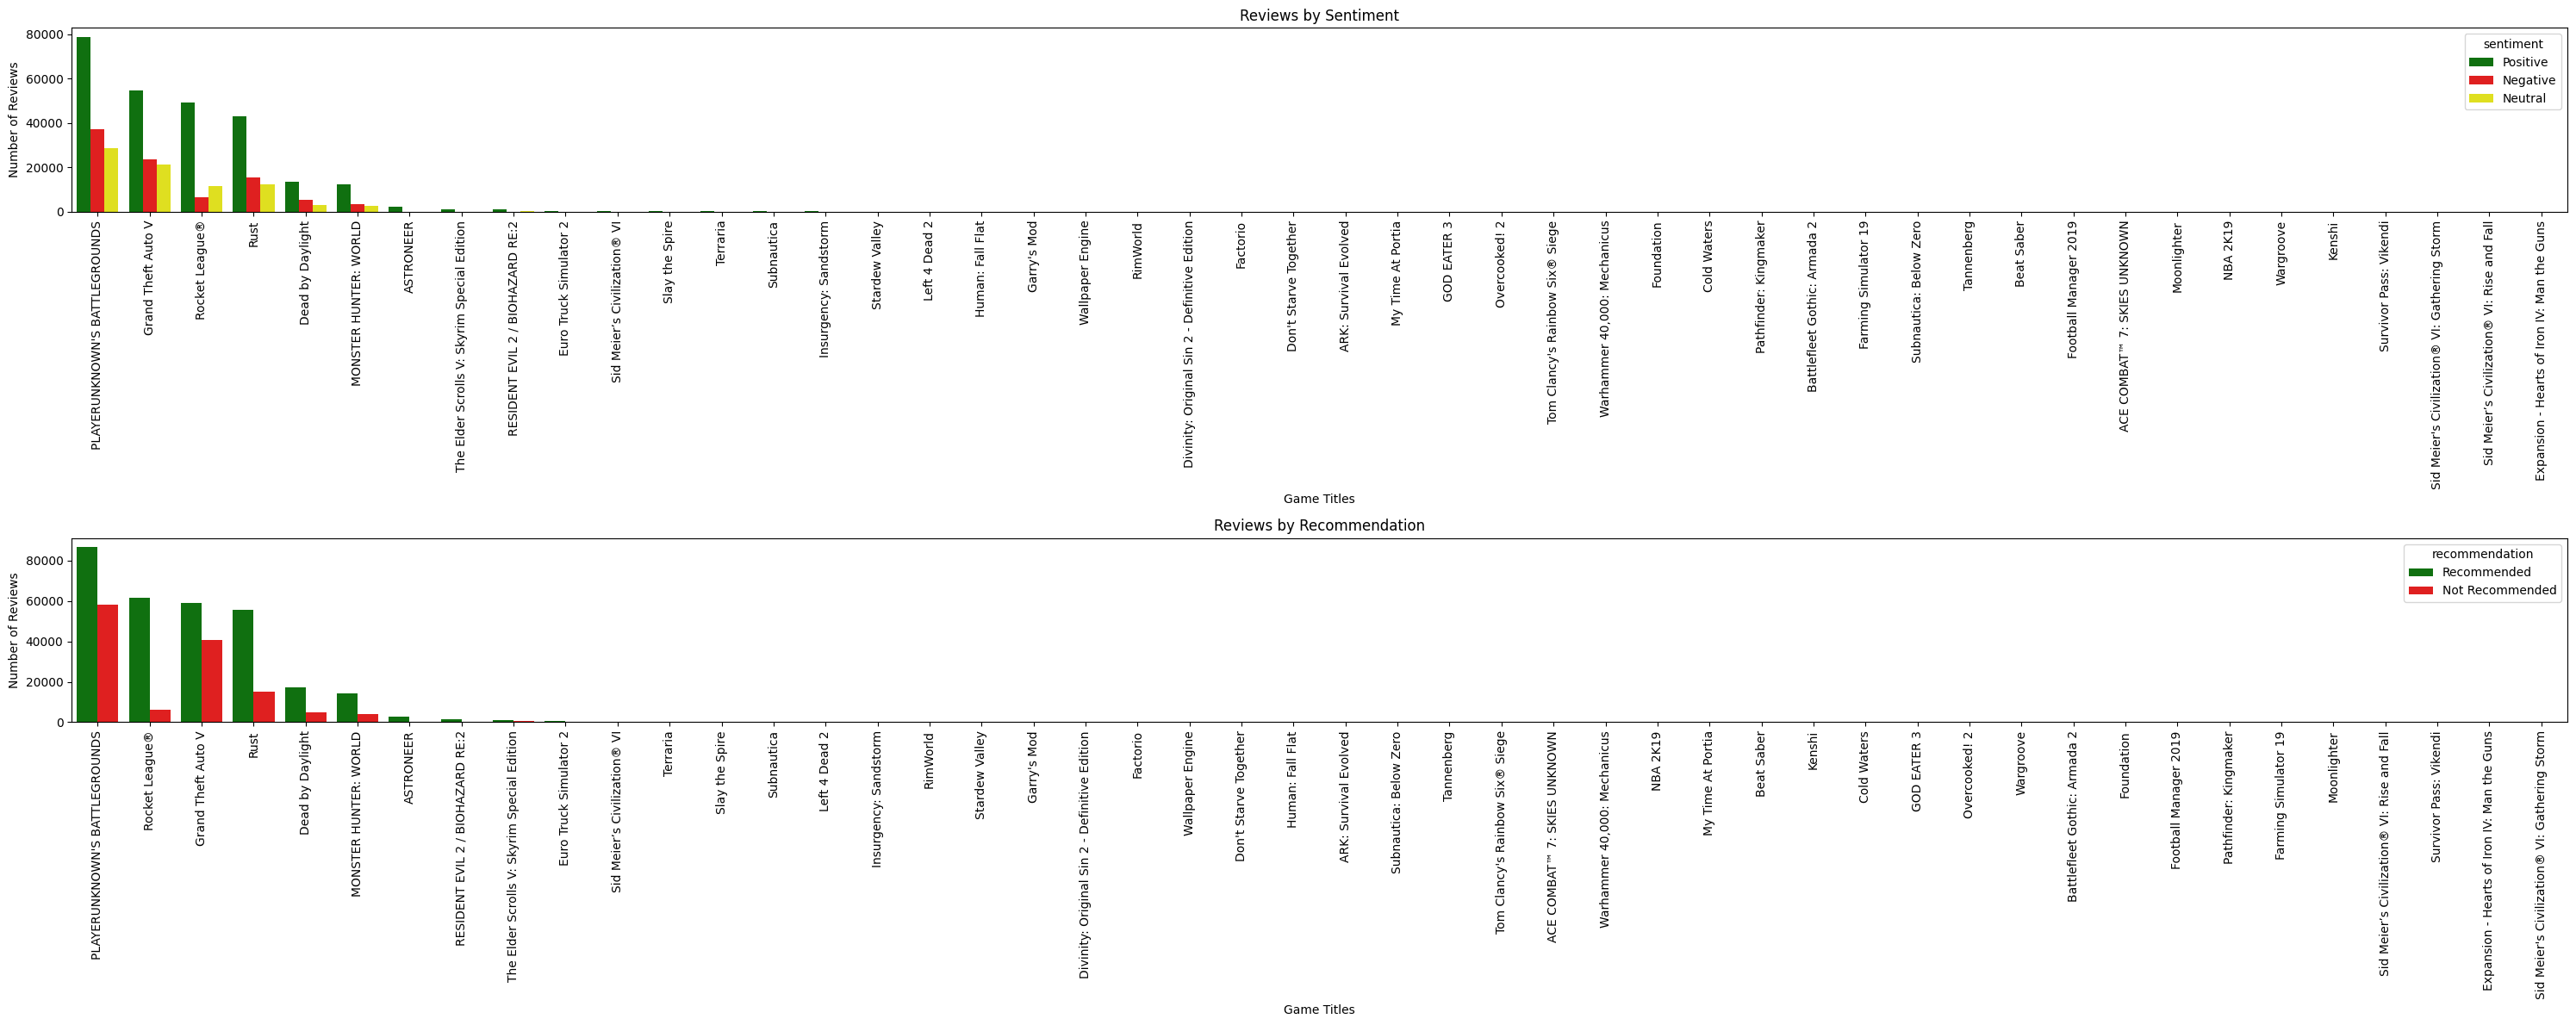

In [49]:
# Set up the figure with two subplots arranged vertically
fig, axes = plt.subplots(2, 1, figsize=(30, 12))

# Define color mappings
color_map_sentiment = {'Positive': 'green', 'Neutral': 'yellow', 'Negative': 'red'}
color_map_recommendation = {'Recommended': 'green', 'Not Recommended': 'red'}

# Bar chart for sentiment
sns.barplot(ax=axes[0], data=reviews_grouped_snt, x='title', y='reviews', hue='sentiment', palette=color_map_sentiment)
axes[0].set_title('Reviews by Sentiment')
axes[0].set_xlabel('Game Titles')
axes[0].set_ylabel('Number of Reviews')
axes[0].tick_params(axis='x', rotation=90)

# Bar chart for recommendation
sns.barplot(ax=axes[1], data=reviews_grouped_rcd, x='title', y='reviews', hue='recommendation',palette=color_map_recommendation)
axes[1].set_title('Reviews by Recommendation')
axes[1].set_xlabel('Game Titles')
axes[1].set_ylabel('Number of Reviews')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()  # Adjust layout to prevent overlapping

plt.show()

**In general the ratio of predicted sentiment / recommendation follows closely the global ratio for majority of titles**

### <a id='toc4_2_2_'></a>[Evaluate accuracy of NLTK model](#toc0_)

In [50]:
steam_reviews['nltk_accuracy'] = np.where(((steam_reviews['recommendation']=='Recommended') & (steam_reviews['sentiment']=='Positive')) | ((steam_reviews['recommendation']=='Not Recommended') & (steam_reviews['sentiment']=='Negative')) | (steam_reviews['sentiment']=='Neutral'),1,0)
steam_reviews['nltk_accuracy'].mean()

0.8215840784539948

Comparing the NLTK sentiment analysis results with the user recommendation being used as the source of truth (and assuming Neutral sentiment predictions to be all correct), we get ~82% accuracy of our predictions.

In [51]:
steam_reviews['nltk_accuracy'] = np.where(((steam_reviews['recommendation']=='Recommended') & (steam_reviews['sentiment']=='Positive')) | ((steam_reviews['recommendation']=='Not Recommended') & (steam_reviews['sentiment']!='Negative')) | (steam_reviews['sentiment']=='Neutral'),1,0)
steam_reviews['nltk_accuracy'].mean()

0.7861620997980964

Accounting for uncertainty regarding the correctness of neutral sentiment predictions, we can consider nltk sentiment analysis model accuracy to be in the range of ~78-82% within this dataset

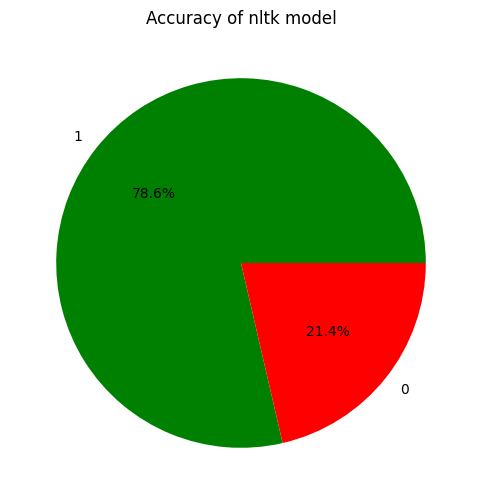

In [54]:
# Calculate counts for each accuracy level
accuracy_counts = steam_reviews['nltk_accuracy'].value_counts()

# Create the pie chart
plt.figure(figsize=(8, 6))
plt.pie(accuracy_counts, labels=accuracy_counts.index, autopct='%1.1f%%', colors=['green','red'])
plt.title('Accuracy of nltk model')
plt.show()

### <a id='toc4_2_3_'></a>[Check accuracy for different groupings of comments](#toc0_)

#### <a id='toc4_2_3_1_'></a>[Drilldown across game titles](#toc0_)

In [56]:
reviews_grouped_acc = steam_reviews[['title','nltk_accuracy']].groupby('title').mean().reset_index().sort_values('nltk_accuracy',ascending=False)

C:\Users\tarka\AppData\Local\Temp\ipykernel_21056\2711003447.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=reviews_grouped_acc, x='title', y='nltk_accuracy', palette='RdYlGn_r')


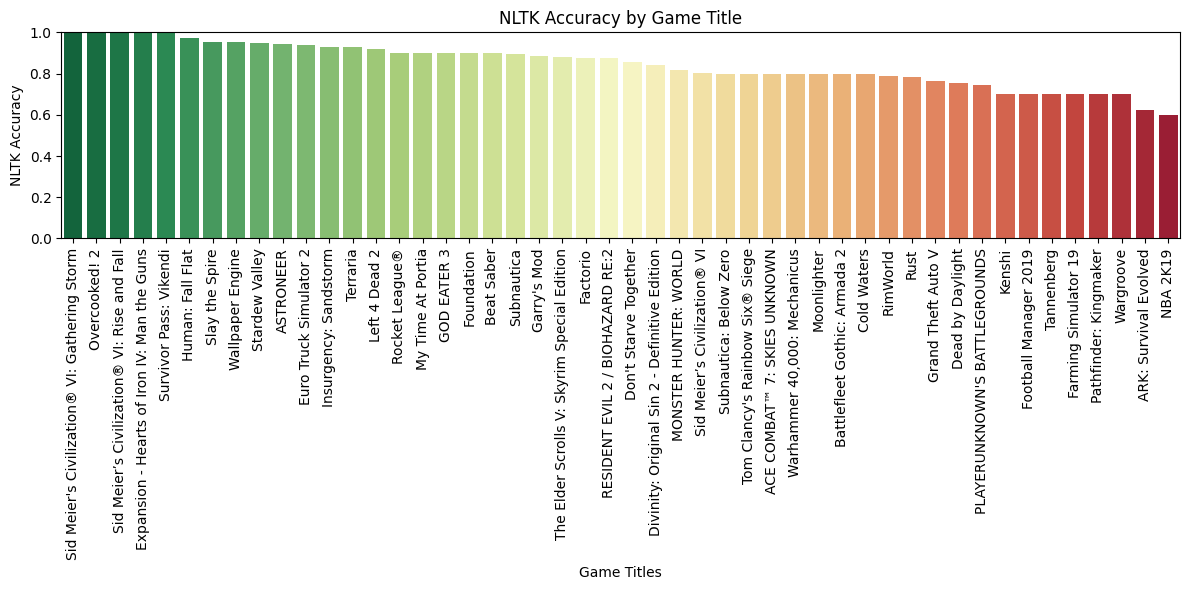

In [58]:
plt.figure(figsize=(12, 6))
sns.barplot(data=reviews_grouped_acc, x='title', y='nltk_accuracy', palette='RdYlGn_r')
plt.title('NLTK Accuracy by Game Title')
plt.xlabel('Game Titles')
plt.ylabel('NLTK Accuracy')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

**Some titles seem to have much lower nltk sentiment prediction accuracy, this might be due to low amount of reviews/comments in general hwoever**

#### <a id='toc4_2_3_2_'></a>[Take amount of reviews into account](#toc0_)

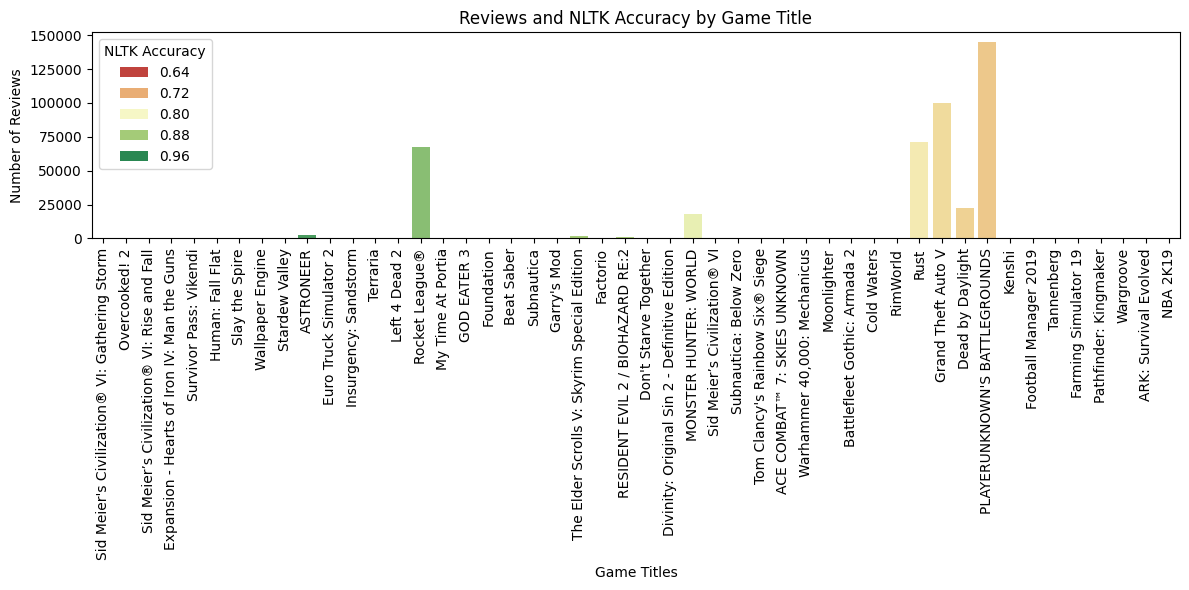

In [59]:
title_count = steam_reviews[['title','review']].groupby('title').count().reset_index()

reviews_grouped_acc= reviews_grouped_acc.merge(title_count, on='title',how='left')

# Create the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=reviews_grouped_acc, x='title', y='review', hue='nltk_accuracy', palette='RdYlGn', dodge=False)
plt.title('Reviews and NLTK Accuracy by Game Title')
plt.xlabel('Game Titles')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.legend(title='NLTK Accuracy', loc='upper left')
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

**No significant nltk accuracy differences can be spotted for titles that make up the majority of reviews**

#### <a id='toc4_2_3_3_'></a>[Only helpful reviews](#toc0_)

**We might assume that the reviews considered as helpful by other users, will be in general more coherent and concise** 

In [61]:
steam_reviews['helpful'] = steam_reviews['helpful'].astype(int)

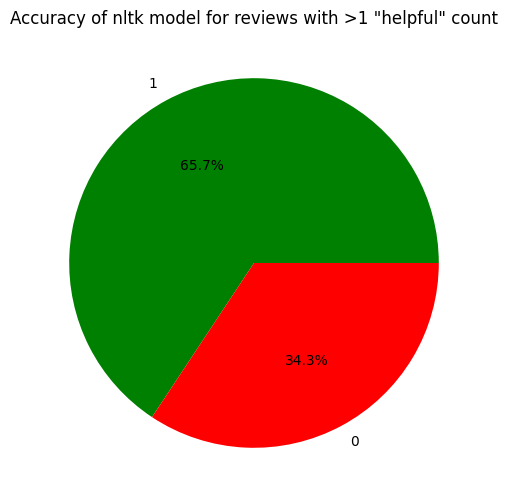

In [63]:
# Filter the DataFrame for reviews with more than 1 "helpful" count
helpful_reviews = steam_reviews[steam_reviews['helpful'] > 1]

# Calculate counts for each accuracy level
accuracy_counts = helpful_reviews['nltk_accuracy'].value_counts()

# Create the pie chart
plt.figure(figsize=(8, 6))
plt.pie(accuracy_counts, labels=accuracy_counts.index, autopct='%1.1f%%', colors=['green','red'])
plt.title('Accuracy of nltk model for reviews with >1 "helpful" count')
plt.show()

**The supposition that limiting the scope to reviews marked as helpful will result in higher nltk sentiment prediction accuracy, has turned out to be incorrect**

#### <a id='toc4_2_3_4_'></a>[Excluding reviews deemed as funny](#toc0_)

**We might want to exclude reviews considered as funny be the users, as the sarcastic tone may be a source of confusion for the model**

In [65]:
steam_reviews['funny'] = steam_reviews['funny'].astype(int)

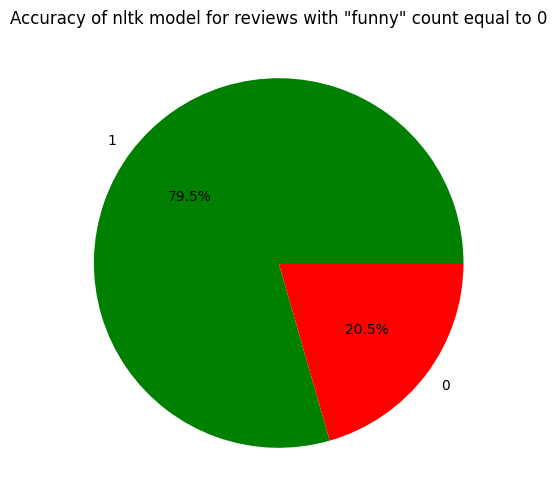

In [66]:
# Filter the DataFrame for reviews where 'funny' column is equal to 0
no_funny_reviews = steam_reviews[steam_reviews['funny'] == 0]

# Calculate counts for each accuracy level
accuracy_counts = no_funny_reviews['nltk_accuracy'].value_counts()

# Create the pie chart
plt.figure(figsize=(8, 6))
plt.pie(accuracy_counts, labels=accuracy_counts.index, autopct='%1.1f%%', colors=['green','red'])
plt.title('Accuracy of nltk model for reviews with "funny" count equal to 0')
plt.show()

**Excluding funny comments improves the nltk predictiosn accuracy marginally, removing comments not deemed as helpful is not helpful to the accuracy**